In [1]:
# https://colab.research.google.com/github/DhavalTaunk08/NLP_scripts/blob/master/sentiment_analysis_using_roberta.ipynb#scrollTo=HMqQTafXEaei

In [1]:
!nvidia-smi

/usr/bin/sh: nvidia-smi: command not found


In [2]:
# !pip install -q -U watermark
# !pip install -qq transformers
# # Update libraries
# !pip install seaborn==0.9.0
# !pip install sklearn
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
df =pd.read_csv('/users/kent/jmaharja/drugAbuse/input/Tweets_Spring_Summer_2021_coded.csv',
                lineterminator='\n',
                skipinitialspace=True,
                usecols= ['Tweet', 'Substance', 'Use', 'Intent']
                )
df

,Tweet,Substance,Use,Intent
0,@aaronaxline @friskycarolina was livid to watc...,X,X,X
1,anyways. im starting my diet on Sunday. i was ...,A,S,A
2,Alcohol and drugs is good for the mind but not...,D,S,A
3,"Now that's jus sad 😂 #BuckeyeNation""62% of Ohi...",X,X,X
4,Bro do you ever get in those moods where you j...,X,X,X
...,...,...,...,...
4462,How much coke she did no wonder age OD'd. Damn.,C,S,X
4463,Ain't no salary cap in the dope game ain't no ...,C,X,X
4464,Aw man they busting out the nose candy &amp; f...,C,N,A
4465,They say crack kill nigga my crack sell #21Savage,C,X,X


In [6]:
df = df.dropna(subset=['Use'])

In [7]:
df.loc[df['Use']=='U']

,Tweet,Substance,Use,Intent
2579,First round of Halloween parties starts tonigh...,G,U,I
3373,Es Friday and everybody juicing,G,U,I


In [8]:
df.loc[df['Use']=='H']

,Tweet,Substance,Use,Intent
3494,Liiike what did she do? was he drunk? https://...,A,H,X


# Labeling Substance Column

0 X Not specific or non-specific substance use
1 S Specific information about substance use
2 N Non-specific information about substance use
3 U *****
4 H *****


{'X': 0, 'S': 1, 'N': 2, 'U': 3, 'H': 4}

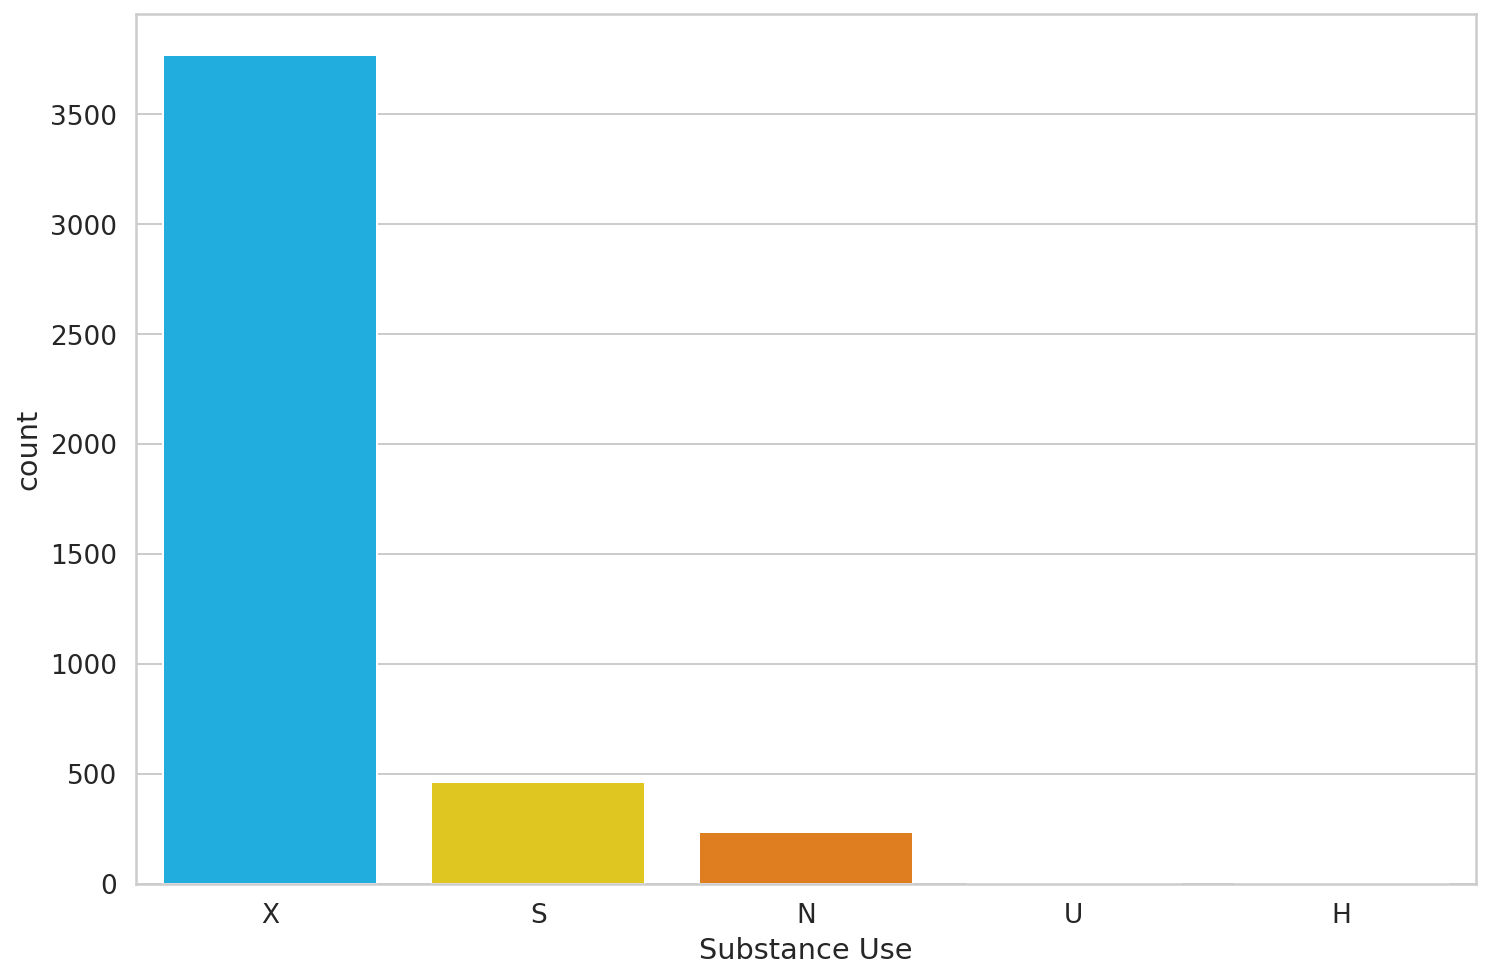

In [19]:
use_class_names = { 'S': 'Specific information about substance use', 
               'N':'Non-specific information about substance use',
               'X':'Not specific or non-specific substance use',
               'U': '*****',
               'H': '*****'
              }
use_possible_labels = df.Use.unique()

use_label_dict = {}
for index, possible_label in enumerate(use_possible_labels):
    use_label_dict[possible_label] = index
for e in use_label_dict.keys():
    print(use_label_dict[e], e, use_class_names[e])
sns.countplot(df.Use)
plt.xlabel('Substance Use')
use_label_dict

In [20]:
# new_df= df['Tweet']
df['label']= df.Use.replace(use_label_dict)
df

,Tweet,Substance,Use,Intent,label
0,@aaronaxline @friskycarolina was livid to watc...,X,X,X,0
1,anyways. im starting my diet on Sunday. i was ...,A,S,A,1
2,Alcohol and drugs is good for the mind but not...,D,S,A,1
3,"Now that's jus sad 😂 #BuckeyeNation""62% of Ohi...",X,X,X,0
4,Bro do you ever get in those moods where you j...,X,X,X,0
...,...,...,...,...,...
4462,How much coke she did no wonder age OD'd. Damn.,C,S,X,1
4463,Ain't no salary cap in the dope game ain't no ...,C,X,X,0
4464,Aw man they busting out the nose candy &amp; f...,C,N,A,2
4465,They say crack kill nigga my crack sell #21Savage,C,X,X,0


# DATA PREPROCESSING

In [14]:
MAX_LEN = 256
from transformers import RobertaTokenizerFast
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel

# Create the tokenizer from a trained one
tokenizer_folder = '/users/kent/jmaharja/drugAbuse/output/TokRoBERTa_april21'
tokenizer = RobertaTokenizerFast.from_pretrained(tokenizer_folder, max_len=MAX_LEN)

Text(0.5, 0, 'Token count')

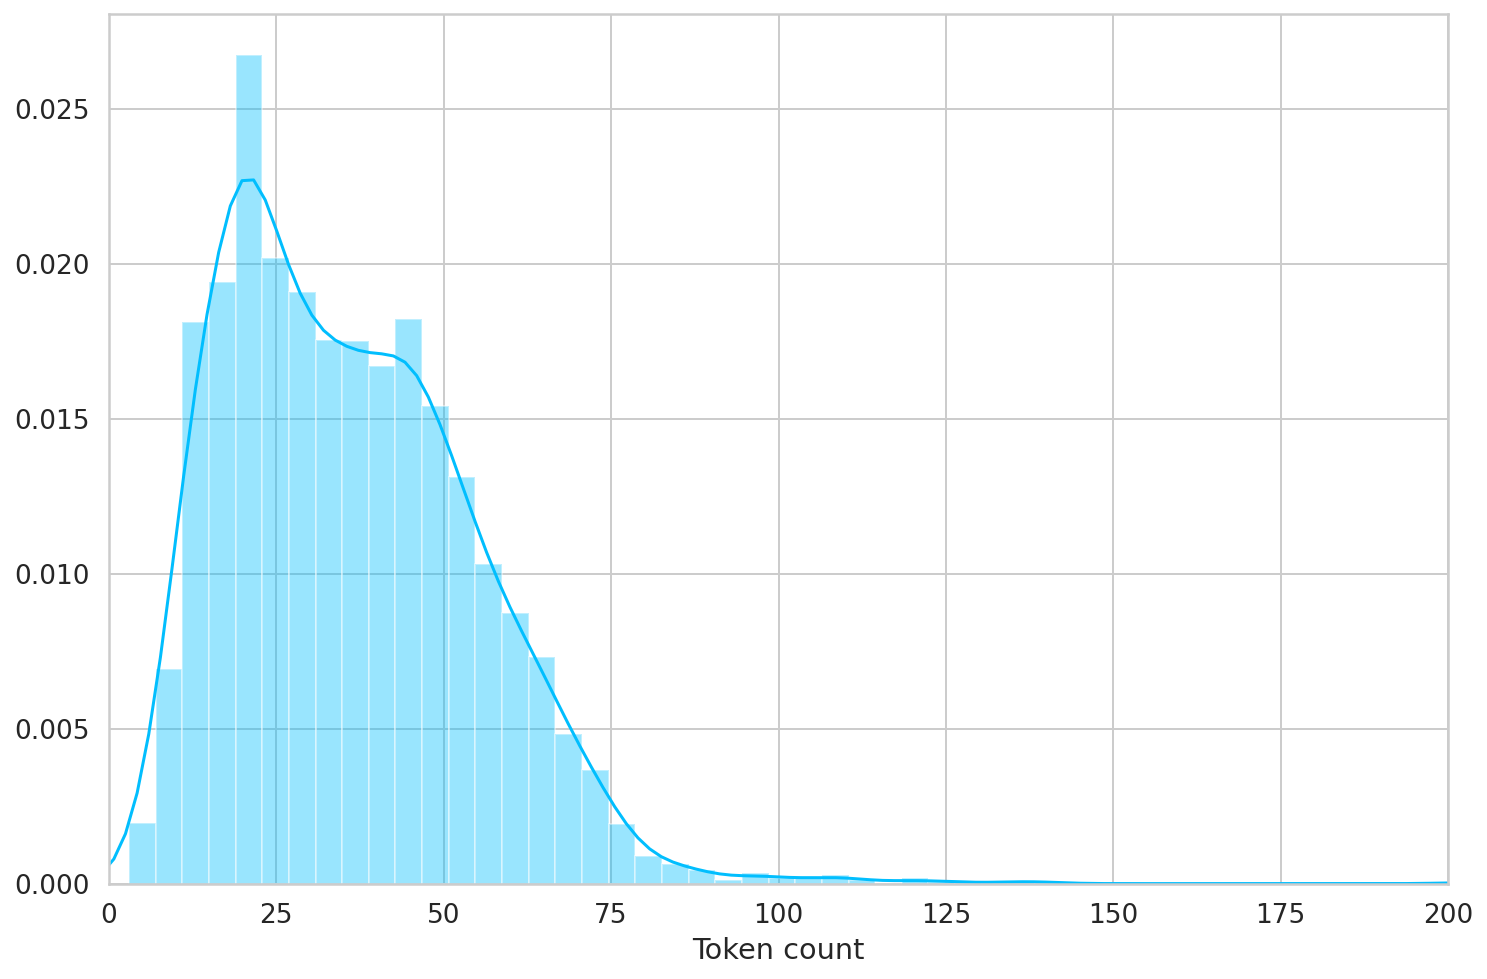

In [15]:
#choosing sequence length
token_lens = []
for txt in df.Tweet:
  tokens = tokenizer.encode(txt)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')

# MAX_LEN = 80

In [27]:
MAX_LEN = 128
df.iloc[1]

Tweet        anyways. im starting my diet on Sunday. i was ...
Substance                                                    A
Use                                                          S
Intent                                                       A
label                                                        1
Name: 1, dtype: object

In [39]:
transformers.__version__ # ==> 17.02

'4.17.0'

In [42]:
sample_text = df.iloc[1]['Tweet']
label = df.iloc[1]['label']
# sample_text = 'This is awesome. We are almost there!'
tokens = tokenizer.encode_plus(
            sample_text,
            None,
            max_length= MAX_LEN,
            truncation=True,
            add_special_tokens=True,
#             pad_to_max_length=True,
            padding = True,
            return_token_type_ids=True
        )
print(f' Sentence: {sample_text}')
print(f' Tokens: {tokens}')
print(f' Tokens.token_type_ids: {tokens.token_type_ids}')
print(f' Tokens.input_ids: {len(tokens.input_ids)}')

output = {
      'input_ids': torch.tensor(tokens.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(tokens.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(tokens.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(label, dtype=torch.long)
    }

output


 Sentence: anyways. im starting my diet on Sunday. i was finna say today, but we havin horse on Saturday. &amp; im fasho finna kai pe ke fiu 😂😂😂😂😂
 Tokens: {'input_ids': [0, 1791, 931, 18, 612, 1784, 368, 296, 2284, 348, 225, 55, 338, 531, 18, 274, 441, 4293, 755, 791, 16, 474, 400, 415, 1756, 2374, 392, 348, 225, 55, 289, 7571, 18, 525, 468, 31, 612, 283, 608, 83, 4293, 387, 689, 517, 903, 283, 3722, 2067, 809, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
 Tokens.token_type_ids: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 Tokens.input_ids: 50


{'input_ids': tensor([   0, 1791,  931,   18,  612, 1784,  368,  296, 2284,  348,  225,   55,
          338,  531,   18,  274,  441, 4293,  755,  791,   16,  474,  400,  415,
         1756, 2374,  392,  348,  225,   55,  289, 7571,   18,  525,  468,   31,
          612,  283,  608,   83, 4293,  387,  689,  517,  903,  283, 3722, 2067,
          809,    2]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 'targets': tensor(1)}

In [50]:
MAX_LEN

128

In [82]:
from torch.utils.data import Dataset

class Tweet_DataSet(Dataset):
   def __init__(self, tweets, targets, tokenizer, max_len):
    self.tweets = tweets
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
   def __len__(self):
    return len(self.tweets)
  
   def __getitem__(self, item):
    tweet = str(self.tweets[item])
    target = self.targets[item]
    encoding = tokenizer.encode_plus(tweet,
                                     None,
                                     max_length = MAX_LEN,
                                     truncation=True,
                                     add_special_tokens=True,
#                                      padding=MAX_LEN,
#                                      padding='longest',
                                     pad_to_max_length=True,
                                     return_token_type_ids=True)

    return {
      'tweet_text': tweet,
      'input_ids': torch.tensor(encoding.input_ids, dtype=torch.long),
      'attention_mask':  torch.tensor(encoding.attention_mask, dtype=torch.long),
      'token_type_ids': torch.tensor(encoding.token_type_ids, dtype=torch.long),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [83]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_train.shape, df_val.shape, df_test.shape

((4020, 5), (223, 5), (224, 5))

In [84]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = Tweet_DataSet(
    tweets=df.Tweet.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [85]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [86]:
data = next(iter(train_data_loader))
print(data.keys())
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['token_type_ids'].shape)
print(data['targets'].shape)

# ds = Tweet_DataSet(df2,tokenizer=tokenizer,max_len=MAX_LEN)
# ds[0]

/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to N

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'token_type_ids', 'targets'])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [114]:
class TweetModel(RobertaPreTrainedModel):
    def __init__(self, conf, n_classes):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained('/users/kent/jmaharja/drugAbuse/output/RoBERTaMLM/', config=conf)
        self.drop_out = nn.Dropout(0.3)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = nn.Linear(768, n_classes)
        
    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.drop_out(pooler)
        output = self.classifier(pooler)
        return output


In [115]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=8192,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)
model = TweetModel(config, len(use_label_dict))
model = model.to(device)

Some weights of the model checkpoint at /users/kent/jmaharja/drugAbuse/output/RoBERTaMLM/ were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at /users/kent/jmaharja/drugAbuse/output/RoBERTaMLM/ and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able

In [91]:
# input_ids = data['input_ids'].to(device)
# attention_mask = data['attention_mask'].to(device)
# token_type_ids = data['token_type_ids'].to(device)
# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length
# print(token_type_ids) # batch size x seq length

# import torch.nn.functional as F
# # To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:
# F.softmax(model(input_ids, attention_mask, token_type_ids), dim=1)

In [116]:
#training
EPOCHS = 16

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [117]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
     
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    token_type_ids = d["token_type_ids"].to(device)
    targets = d["targets"].to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

    big_val, big_idx = torch.max(outputs, dim=1)
    correct_predictions += torch.sum(big_idx == targets)

    loss = loss_fn(outputs, targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double()/n_examples, np.mean(losses)

In [118]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        token_type_ids=token_type_ids
      )
      _, preds = torch.max(outputs, dim=1)
      correct_predictions += torch.sum(preds == targets)

      loss = loss_fn(outputs, targets)
      losses.append(loss.item())

  return correct_predictions.double()/n_examples, np.mean(losses)

In [119]:
from os.path import exists
# %%time

# set to True if you want to train the model
# otherwise use the existing trained model
FORCE_TRAIN = True

# download trained model
# !gdown --id 1QQ2d0_yFStL2rXz2eHoXpgRMvPWtMMeX


history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):


#   modelPath = "/content/best_model_state.bin"
#   if (exists(modelPath) and FORCE_TRAIN == False ): # if model exists load it otherwise rebuild
#     torch.load(modelPath)
#     break # exit out of training
  

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/16
----------
Train loss 0.42430261713230893 accuracy 0.8604477611940298
Val   loss 0.33630611108882086 accuracy 0.8878923766816144

Epoch 2/16
----------
Train loss 0.2515143910519934 accuracy 0.9134328358208955
Val   loss 0.3788109230143683 accuracy 0.8878923766816144

Epoch 3/16
----------
Train loss 0.154840442377174 accuracy 0.9512437810945273
Val   loss 0.4608918513570513 accuracy 0.8654708520179372

Epoch 4/16
----------
Train loss 0.08349921105723802 accuracy 0.9758706467661691
Val   loss 0.5020801376750959 accuracy 0.8834080717488789

Epoch 5/16
----------
Train loss 0.03758512406287962 accuracy 0.9907960199004975
Val   loss 0.5547731824585104 accuracy 0.905829596412556

Epoch 6/16
----------
Train loss 0.019428413171500857 accuracy 0.9950248756218905
Val   loss 0.6127335709066496 accuracy 0.8878923766816144

Epoch 7/16
----------
Train loss 0.009604459164562748 accuracy 0.9977611940298506
Val   loss 0.7241552915932387 accuracy 0.8923766816143498

Epoch 8/16
----------

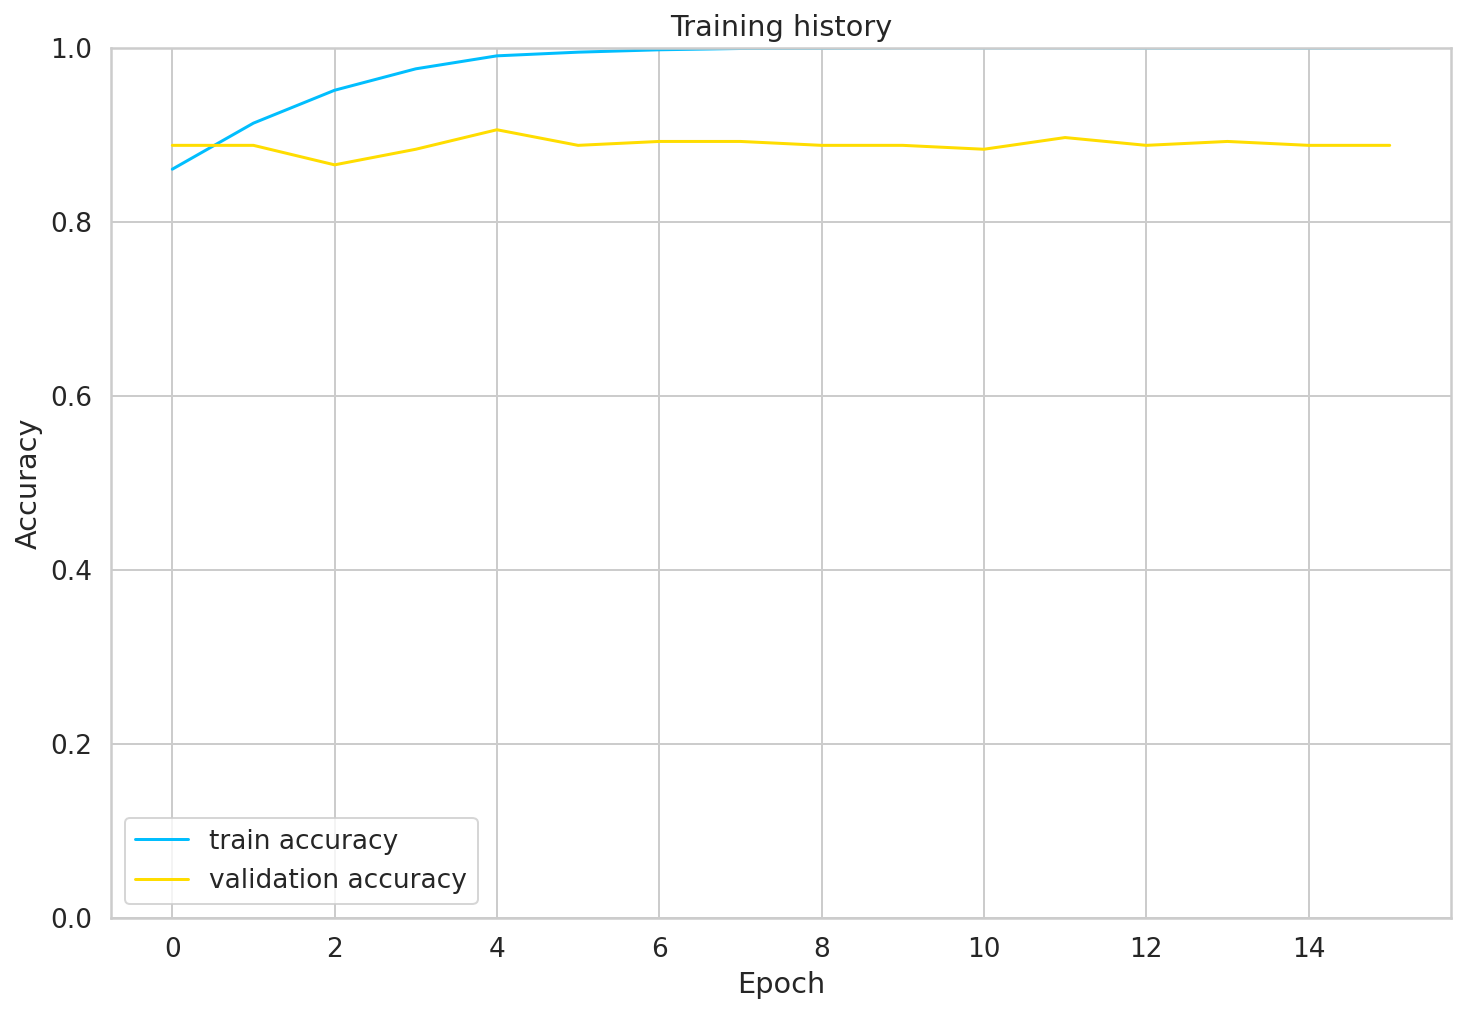

In [120]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [121]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8794642857142857

In [122]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      token_type_ids = d["token_type_ids"].to(device)
      targets = d["targets"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
      _, preds = torch.max(outputs, dim=1)
      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [123]:
import torch.nn.functional as F
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [124]:
y_review_texts,y_pred_probs, y_pred, y_test

(["@5daysoffalling @Love_bug1016 yea it's called crack",
  "@Feathertitties if I can't make a joke about blue balls then conservative old men shouldn't write laws about peoples' uteri. #logic",
  'Save a horse, ride a cowboy',
  '@15BMcNaughton I sent screenshots. ;)',
  "Out being high-octane basic with the love of my life @michaelhiggy @ Quattro Goomba's Winery https://t.co/bsnLnKiXbD",
  'Fuck you and your heroin jokes',
  'a never ending debate: should i drink the wine or not',
  '@TezMillerOz @KelleyArmstrong @katedetweiler @amyewingbooks @miragrant @griffski @RC_Lewis @wordpressdotcom Thanks Tez!',
  'First round of Halloween parties starts tonight. Lets get lit people. Party scene been dead for too long, lets get it poppin',
  '#CandySongs Rocky Mountain Milky Way',
  'YES OMFG😂😂😂😂 @becca_lynn5689 @KenziBrowning https://t.co/kPQKSKepzn',
  '#View@fatbellybella New Show@LegendsofCH ON @ComedyCentral#IndustryFixx #LegendsOfCH @iamcarljoneshttps://t.co/P2zEeZpFaU',
  'Gov: "The bot

In [125]:
a = y_test.numpy

In [126]:
someListOfLists = list(zip(y_review_texts, y_test, y_pred, y_pred_probs ))
npa = np.asarray(someListOfLists)
dff = pd.DataFrame(someListOfLists, columns = ['tweet', 'Real', 'Predicted', 'Pred-prob'])
# dff['Real']= pd.to_numeric(df["Real"])
dff

,tweet,Real,Predicted,Pred-prob
0,@5daysoffalling @Love_bug1016 yea it's called ...,tensor(2),tensor(0),"[tensor(1.0000), tensor(5.7878e-06), tensor(3...."
1,@Feathertitties if I can't make a joke about b...,tensor(0),tensor(0),"[tensor(1.0000), tensor(4.1119e-06), tensor(1...."
2,"Save a horse, ride a cowboy",tensor(0),tensor(1),"[tensor(0.0367), tensor(0.9628), tensor(0.0004..."
3,@15BMcNaughton I sent screenshots. ;),tensor(0),tensor(0),"[tensor(1.0000), tensor(6.3723e-06), tensor(3...."
4,Out being high-octane basic with the love of m...,tensor(1),tensor(0),"[tensor(1.0000), tensor(5.1873e-06), tensor(6...."
...,...,...,...,...
219,@LaikaSpaceDog @RosieGray @katherinemiller oth...,tensor(0),tensor(0),"[tensor(1.0000), tensor(4.8387e-06), tensor(3...."
220,Cleared: Incident on #I95 SB from Rosedale Ave...,tensor(0),tensor(0),"[tensor(1.0000), tensor(4.6445e-06), tensor(5...."
221,One of these days I'm actually gonna do cocaine.,tensor(1),tensor(2),"[tensor(0.0010), tensor(0.0327), tensor(0.9662..."
222,#apple #pie assembly. Photo creds: ambersuepho...,tensor(0),tensor(0),"[tensor(1.0000), tensor(6.4430e-06), tensor(5...."


In [127]:
# class_names, label_dict, possible_labels
# label_dict.keys()
# y_pred


possible_labels_test = df_test.Use.unique()
possible_labels_test
# label_dict = {}
# for index, possible_label in enumerate(possible_labels):
#     label_dict[possible_label] = index
# label_dict

array(['N', 'X', 'S', 'U'], dtype=object)

In [128]:
use_class_names

{'S': 'Specific information about substance use',
 'N': 'Non-specific information about substance use',
 'X': 'Not specific or non-specific substance use',
 'U': '*****',
 'H': '*****'}

In [129]:
print(classification_report(y_test, y_pred, target_names=possible_labels_test))

              precision    recall  f1-score   support

           N       0.92      0.96      0.94       186
           X       0.60      0.65      0.63        23
           S       0.60      0.21      0.32        14
           U       0.00      0.00      0.00         1

    accuracy                           0.88       224
   macro avg       0.53      0.46      0.47       224
weighted avg       0.87      0.88      0.87       224



/users/kent/jmaharja/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


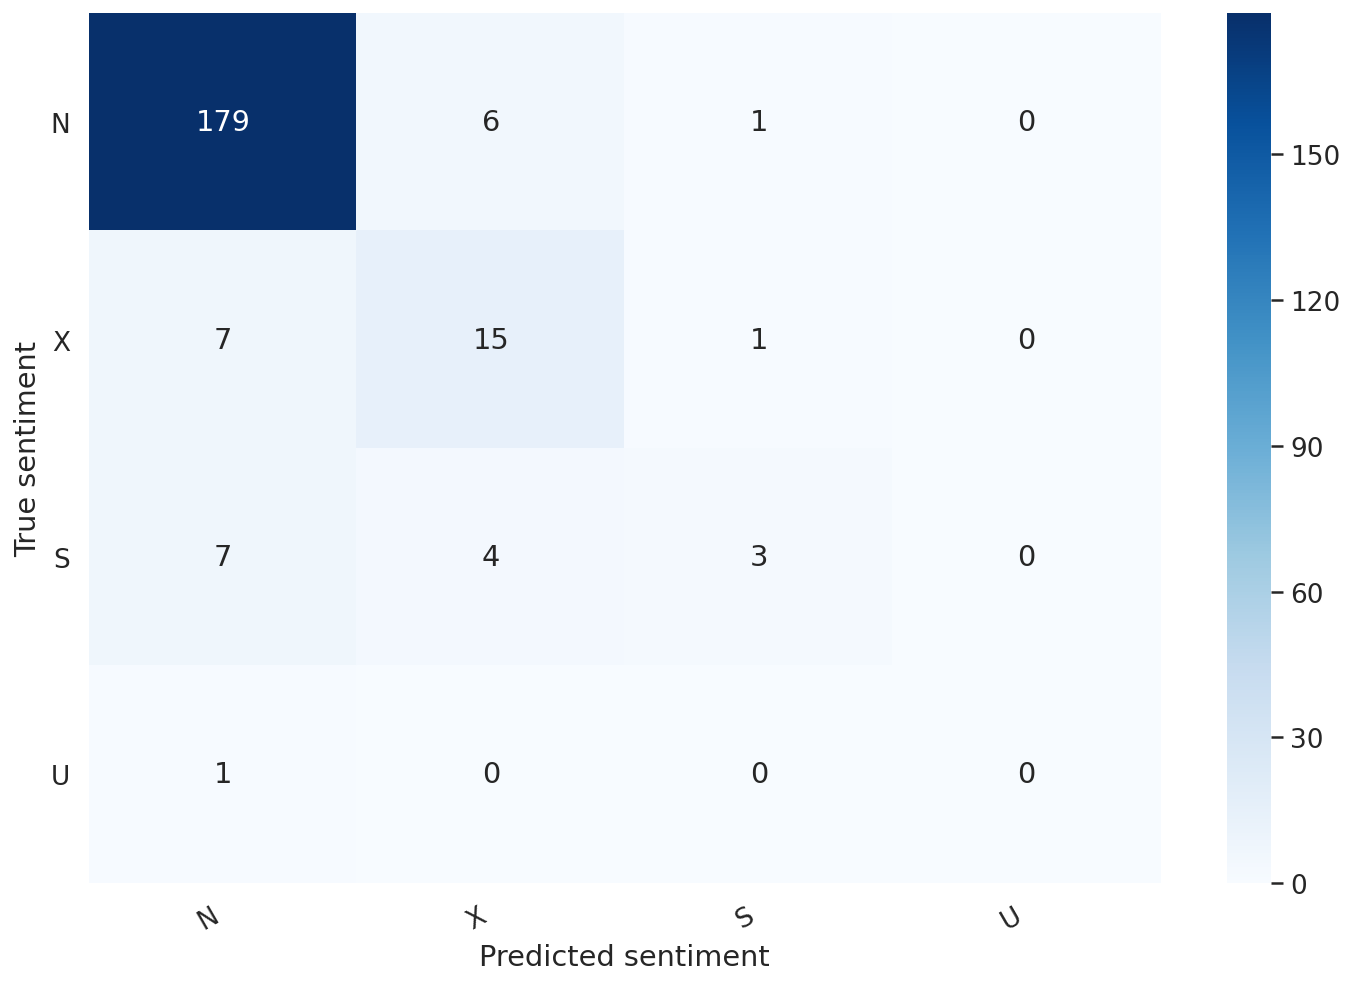

In [130]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=possible_labels_test, columns=possible_labels_test)
show_confusion_matrix(df_cm)

In [131]:
idx = 15
idx = 99

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': use_possible_labels,
  'values': y_pred_probs[idx]
})
true_sentiment, y_pred[idx]

(tensor(1), tensor(1))

In [132]:
pred_df

,class_names,values
0,X,0.000299
1,S,0.999404
2,N,0.000279
3,U,0.000008
4,H,0.000010


In [133]:
# possible_labels,class_names,true_sentiment

In [134]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {use_possible_labels[true_sentiment]}')
print(f'True sentiment category fullname: {use_class_names[use_possible_labels[true_sentiment]]}')

In a cab &amp; the girls next to me snorting cocaine...I like this
cab.

True sentiment: S
True sentiment category fullname: Specific information about substance use


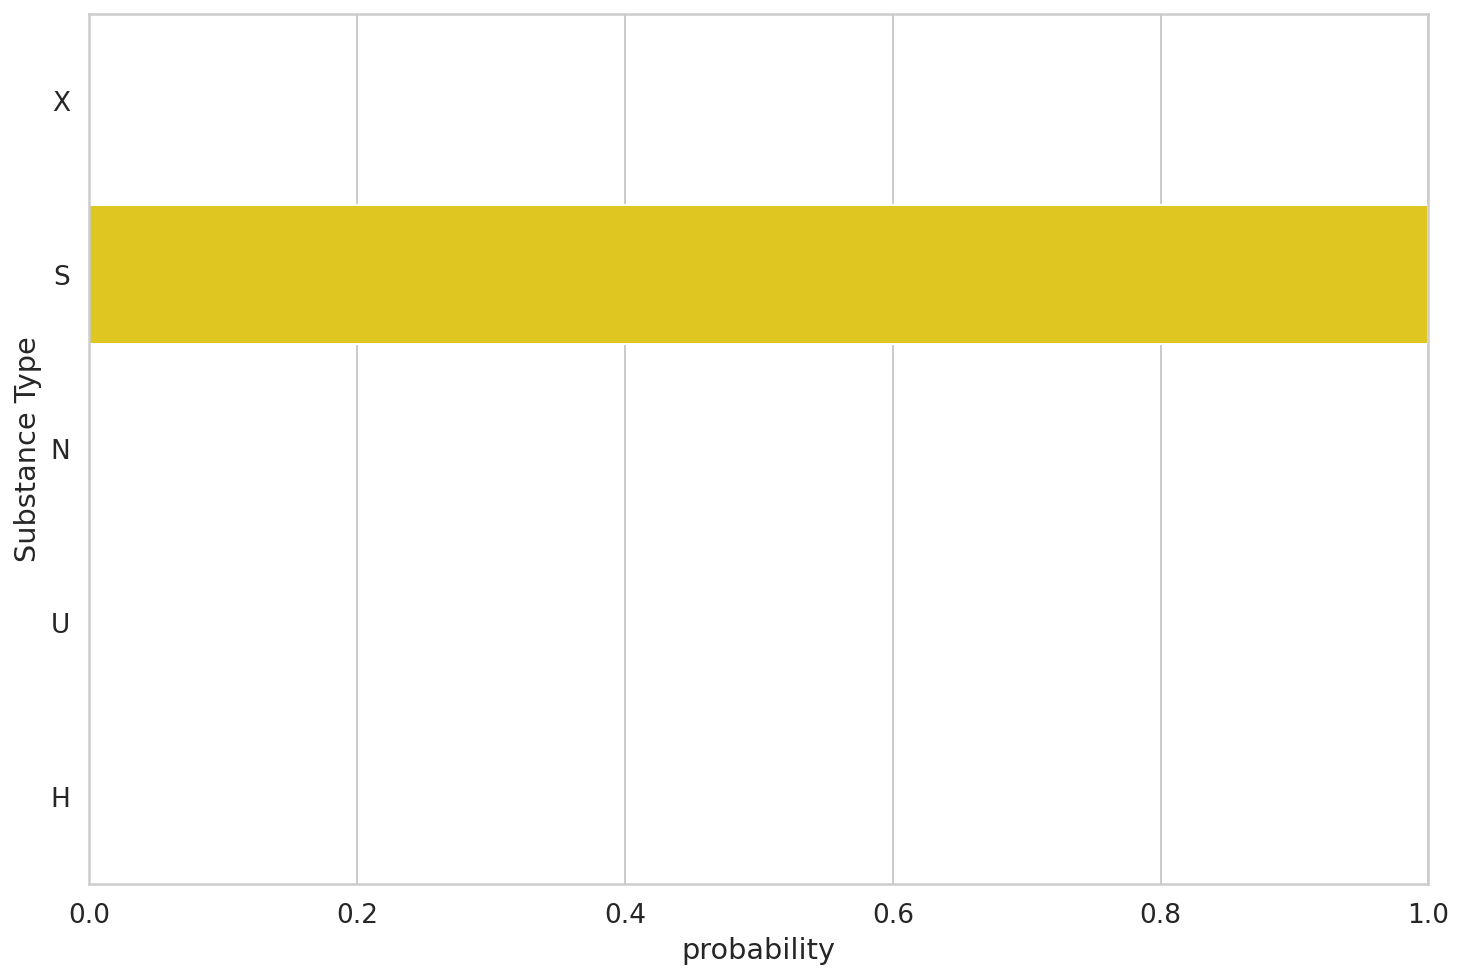

In [135]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Substance Type')
plt.xlabel('probability')
plt.xlim([0, 1]);

Predicting on Raw Text

In [136]:
tweet = "Some shots from my shoot for F.I.T. Studio. Coach Fred"
encoded_tweet = tokenizer.encode_plus(
  tweet,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
input_ids = encoded_tweet['input_ids'].to(device)
attention_mask = encoded_tweet['attention_mask'].to(device)
token_type_ids = encoded_tweet['token_type_ids'].to(device)


output = model(input_ids, attention_mask, token_type_ids)
_, prediction = torch.max(output, dim=1)
print(f'Tweet text: {tweet}')
print(f'Substance Use  : {use_possible_labels[prediction]}')

Tweet text: Some shots from my shoot for F.I.T. Studio. Coach Fred
Substance Use  : X


/users/kent/jmaharja/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
